In [1]:
# Import standard libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import time
import re
import io
from scipy import sparse as sp
from scipy.sparse.linalg import norm
from collections import defaultdict
from inspect import signature
import sklearn.preprocessing as pp
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, display, HTML

#Import from surprise library
from surprise import Dataset
from surprise import get_dataset_dir
from surprise import KNNBasic, KNNWithMeans, SVD
from surprise.model_selection import train_test_split 
from surprise.model_selection import cross_validate, GridSearchCV

# Set some formatting options
plt.style.use('dark_background')
np.set_printoptions(threshold=500, precision=4)
pd.options.display.max_seq_items = 20
pd.options.display.max_rows = 20

# Recommender Systems

<img src='https://imgs.xkcd.com/comics/star_ratings.png' width="300">

Source: [xkcd 1908](https://xkcd.com/1098/)

## Content

The goal of this walkthrough is to provide you with insights on recommender systems. A [recommender system](https://en.wikipedia.org/wiki/Recommender_system) is a subclass of information filtering system that seeks to predict the "rating" or "preference" a user would give to an item. They are primarily used in commercial applications.

In this notebook, we will see how to implement a recommender from scratch before using the surprise library:
- [Implementing User-User Collaborative Filtering from scratch](#Implementing-User-User-Collaborative-Filtering-from-scratch)
    - [Load data](#Load-data)
    - [Data visualization](#Data-visualization)
    - [Preprocessing](#Preprocessing)
    - [Create the Ratings Matrix](#Create-the-Ratings-Matrix)
    - [User Average Ratings](#User-Average-Ratings)
    - [Compute User-User Similarity](#Compute-User-User-Similarity) 
    - [User to all Users Similarities](#User-to-all-Users-Similarities)
    - [Create User Neighborhood](#Create-User-Neighborhood) 
    - [Predict a Rating](#Predict-a-Rating) 
    - [Recommendation](#Recommendation)
- [Using the Surprise library](#Using-the-Surprise-library)
    - [Building a recommender system](#Building-a-recommender-system)
    - [Visualizing the recommendations](#Visualizing-the-recommendations)
    - [Precision and Recall at rank k](#Precision-and-Recall-at-rank-k)
    - [Precision-recall curve](#Precision-recall-curve)
    - [Cross-validation](#Cross-validation)
    - [Tuning hyper-parameters](#Tuning-hyper-parameters)

## Implementing User-User Collaborative Filtering from scratch

Our goal is to implement User-User Collaborative Filtering from scratch, i.e., by only using `numpy` and `scipy` libraries.

### Load data

We will use the MovieLens dataset, which contains movie ratings collected from the MovieLens website by the [GroupLens](https://grouplens.org/) research lab, and more specifically the [small dataset for education and development](https://grouplens.org/datasets/movielens/).

Source: F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. *ACM Transactions on Interactive Intelligent Systems (TiiS)* 5, 4: 19:1–19:19. <https://doi.org/10.1145/2827872>

In [2]:
project_dir = r"C:\Users\Charlotte Ahrens\Documents\Personal\GitHub\MGT-502-Data-Science-and-Machine-Learning\data\ml-latest-small"

In [3]:
# Load data
ratings_raw = os.path.join(project_dir,"ratings.csv")
movies = os.path.join(project_dir,"movies.csv")
links = os.path.join(project_dir,"links.csv")
ratings_raw = pd.read_csv(ratings_raw)
movies = pd.read_csv(movies)
links = pd.read_csv(links)
#ratings_raw = pd.read_csv('https://raw.githubusercontent.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/main/data/ml-latest-small/ratings.csv')
#movies = pd.read_csv('https://raw.githubusercontent.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/main/data/ml-latest-small/movies.csv')
#links = pd.read_csv('https://raw.githubusercontent.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/main/data/ml-latest-small/links.csv')

The "ratings.csv" dataset contains the ratings given to movies by users:

In [4]:
display(ratings_raw.head())
print("Distinct users:", len(ratings_raw.userId.unique()))
print("Distinct movies:", len(ratings_raw.movieId.unique()))

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Distinct users: 610
Distinct movies: 9724


Note that the movies are identified by an Id number. The "movies.csv" file gives us the title corresponding to a given Id number:

In [5]:
display(movies.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Finally, the "links.csv" file gives the identifiers that can be used to link to other sources of movie data, such as [IMDb](https://www.imdb.com/) and The Movie Database ([TMDb](https://www.themoviedb.org/)):

In [6]:
display(links.head())

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


### Data visualization

Lets visualize some of the movie data. We will use [tmdbsimple](https://pypi.org/project/tmdbsimple/) which is a wrapper, written in Python, for The Movie Database (TMDb) API v3. You can install tmdbsimple with the following line of code in your terminal:

```python
pip install tmdbsimple
``` 

*Note*: You could also install a module directly from a Jupyter Notebook by using `!pip install`. The exclamation mark `!` allows you to run shell commands from inside a Jupyter Notebook code cell. However, you need to be careful when doing so since this could lead to some errors. For further information, see this discussion on how to [Install Python Packages from a Jupyter Notebook](https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/).

We will also directly import a module from GitHub using the [httpimport](https://pypi.org/project/httpimport/) module. As before, you can install it with the following line of code:

```python
pip install httpimport
``` 

We import the "TMDB_class" module, which contains a class we need called `TMDB`:

In [7]:
# Import module from GitHub
import httpimport
with httpimport.remote_repo('https://github.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/tree/main/07_Recommenders/TMDB_class'):
    import TMDB_class

TMDB_class

<module 'TMDB_class' from 'c:\\Users\\Charlotte Ahrens\\Documents\\Personal\\GitHub\\MGT-502-Data-Science-and-Machine-Learning\\07_Recommenders\\TMDB_class\\__init__.py'>

We now define two functions to help us in our exploration. The first function returns the HTML format of an image URL. The second function is using the first one to show the movie posters of the top rated movies for a given user identifier. 

In [8]:
# Image url in html format
def make_html(image_url):
     return '<img src="{}" style="display:inline;margin:1px" width="100"/>'\
            .format(image_url)

# Display movie posters from userID    
def show_movies_for_user(userId, verbose=False, show_all=False):
    """Retrieve posters of top rated movies for userId.
    """
    html = ''
    max_movies = 10
    i=0
    
    # Extract all movies watched by user, sorted by rating
    user_movies = ratings_raw[ratings_raw.userId == userId].sort_values("rating", ascending=False)
    # Print number of watched movies
    print(f'User {userId} watched {len(user_movies)} movies.') 
    
    # Loop through the movies to retrieve posters
    for index, row in user_movies.iterrows():
        movieId = row["movieId"]                         # Extract MovieLens movie Id                 
        movie_item = links[links.movieId == movieId]     # Extract row corresponding to movieId from links dataset
        tmdbId = movie_item["tmdbId"].item()             # Extract TMDb movie Id
        # Print Id of movies in MovieLens and in TMDb is verbose=True
        if verbose:
            print(movieId, tmdbId)
        # Retrieve TMDb movie poster url    
        if np.isnan(tmdbId):
            url = None
        else:
            url = TMDB_class.TMDB().get_poster_path_by_id(int(tmdbId)) # use imported module
        html = html + make_html(url)                                   # convert image url to html
        i +=1
        # Only display top 10 movies if show_all = False
        if ~show_all and (i == max_movies):
                break
        
    display(HTML(html))

Let's see the top 10 movies watched by user 6:

In [9]:
show_movies_for_user(6, verbose=False)
show_movies_for_user(6, verbose= True) # adds the movie ID and the tmdbID (gives a number to the movie in the Movie Database)

User 6 watched 314 movies.


User 6 watched 314 movies.
318.0 278.0
364.0 8587.0
587.0 251.0
356.0 13.0
780.0 602.0
783.0 10545.0
257.0 9061.0
350.0 10731.0
349.0 9331.0
3.0 15602.0


Unsurprisingly, the Lion King is among the top. Let's display the ratings and general information on these movies:

In [10]:
(ratings_raw[ratings_raw.userId == 6]                       # Extract movies ratings for user ID = 6
            .sort_values("rating", ascending=False)         # Sort by rating
            .head(10)                                       # Extract top 10 movies
            .set_index('movieId')                           # Reset index by movie Id
            .join(movies.set_index('movieId'), on='movieId') # Join with movies dataframe
)

,userId,rating,timestamp,title,genres
movieId,,,,,
318,6,5.0,845553200,"Shawshank Redemption, The (1994)",Crime|Drama
364,6,5.0,845553317,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
587,6,5.0,845553381,Ghost (1990),Comedy|Drama|Fantasy|Romance|Thriller
356,6,5.0,845553200,Forrest Gump (1994),Comedy|Drama|Romance|War
780,6,5.0,845556915,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller
783,6,5.0,845554584,"Hunchback of Notre Dame, The (1996)",Animation|Children|Drama|Musical|Romance
257,6,5.0,845554176,Just Cause (1995),Mystery|Thriller
350,6,5.0,845553489,"Client, The (1994)",Drama|Mystery|Thriller
349,6,5.0,845553146,Clear and Present Danger (1994),Action|Crime|Drama|Thriller


We now define additional functions to pursue our analysis. The first one returns the name of a movie using the associated identifier. The second one plots a histogram of movies genres watched by one user:

In [11]:
def get_name_for_movie_id(movie_id):
    """Returns the name of a movie_id (based on ratings_raw i.e. original id)"""    
    try: 
        movie_name = movies[movies.movieId == movie_id]["title"].item()
    except KeyError:
        movie_name = None
    return movie_name
    
    
def show_genres_histogram_for_user(user_id):
    """Create histogram of movies genres user_id has watched.
    """
    # Extract movie Ids
    user_movies = ratings_raw[ratings_raw.userId == user_id]["movieId"]
    # Print number of watch movies
    print(f'User {user_id} watched {len(user_movies)} movies.') 
    # Extract dataframe with title and genre of movies watched
    user_movies_with_genre = movies[movies.movieId.isin(user_movies)]
    display(user_movies_with_genre)
    # List of all genres of movies watched (include duplicates)
    genres_list = []
    for index, row in user_movies_with_genre.iterrows():
        genres_list += row["genres"].split('|')
    # Dataframe of all genres
    df_genres = pd.DataFrame(genres_list, columns=['Genres'])
    # Histogram of movies genres
    df_genres.groupby('Genres').size().sort_values().plot(kind='barh')

Let's check our function:

In [12]:
get_name_for_movie_id(364)

'Lion King, The (1994)'

User 6 watched 314 movies.


,movieId,title,genres
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
...,...,...,...
811,1061,Sleepers (1996),Thriller
812,1064,Aladdin and the King of Thieves (1996),Animation|Children|Comedy|Fantasy|Musical|Romance
815,1073,Willy Wonka & the Chocolate Factory (1971),Children|Comedy|Fantasy|Musical
822,1082,"Candidate, The (1972)",Drama


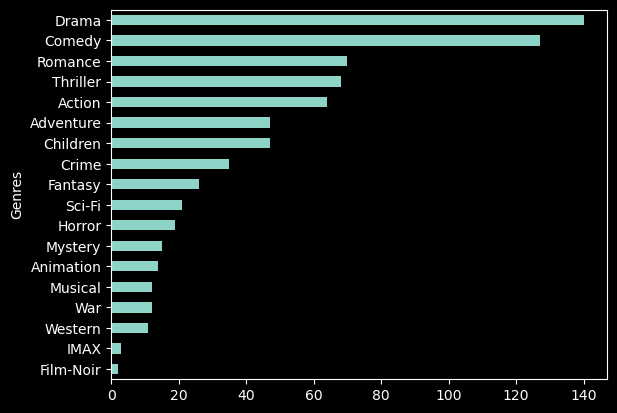

In [13]:
show_genres_histogram_for_user(6)

### Preprocessing

To create our ratings matrix, we need to make sure that movies and users have consecutive indexes starting from 0. We thus create two dictionaries mapping: 1) the movie identifiers (movieId) to movies indices (movieIDX); 2) the users identifiers (userId) to users indices (userIDX). 

In [14]:
ratings_raw

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [15]:
# Extract and sort unique movies and users
movieIds = ratings_raw.movieId.unique() # how man different movies are in the list
movieIds.sort()
userIds = ratings_raw.userId.unique() #how many different users are in the lsit
userIds.sort()

# Size
m = movieIds.size
n = userIds.size
numRatings = len(ratings_raw)
print(f'There are {n} users, {m} movies, and {numRatings} ratings.')

## Movies and users should have consecutive indexes starting from 0
# Dictionaries to convert movie id to consecutive index and vice versa
movieId_to_movieIDX = dict(zip(movieIds, range(0, m)))
movieIDX_to_movieId = dict(zip(range(0, m), movieIds))
# Dictionaries to convert user id to consecutive index and vice versa
userId_to_userIDX = dict(zip(userIds, range(0, n)))
userIDX_to_userId = dict(zip(range(0, n), userIds))

There are 610 users, 9724 movies, and 100836 ratings.


In [16]:
userId_to_userIDX

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 22: 21,
 23: 22,
 24: 23,
 25: 24,
 26: 25,
 27: 26,
 28: 27,
 29: 28,
 30: 29,
 31: 30,
 32: 31,
 33: 32,
 34: 33,
 35: 34,
 36: 35,
 37: 36,
 38: 37,
 39: 38,
 40: 39,
 41: 40,
 42: 41,
 43: 42,
 44: 43,
 45: 44,
 46: 45,
 47: 46,
 48: 47,
 49: 48,
 50: 49,
 51: 50,
 52: 51,
 53: 52,
 54: 53,
 55: 54,
 56: 55,
 57: 56,
 58: 57,
 59: 58,
 60: 59,
 61: 60,
 62: 61,
 63: 62,
 64: 63,
 65: 64,
 66: 65,
 67: 66,
 68: 67,
 69: 68,
 70: 69,
 71: 70,
 72: 71,
 73: 72,
 74: 73,
 75: 74,
 76: 75,
 77: 76,
 78: 77,
 79: 78,
 80: 79,
 81: 80,
 82: 81,
 83: 82,
 84: 83,
 85: 84,
 86: 85,
 87: 86,
 88: 87,
 89: 88,
 90: 89,
 91: 90,
 92: 91,
 93: 92,
 94: 93,
 95: 94,
 96: 95,
 97: 96,
 98: 97,
 99: 98,
 100: 99,
 101: 100,
 102: 101,
 103: 102,
 104: 103,
 105: 104,
 106: 105,
 107: 106,
 108: 107,
 109: 108,
 110: 109,
 111: 11

We therefore have an index (IDX) , which we want to start at 0 and an ID for each movie (item) and each user.

In [17]:
# Users id to index
for id in range(0, 10):
    try:
        print(id, userId_to_userIDX[id])
    except:
        print('There is nobody with id = ' + str(id))

There is nobody with id = 0
1 0
2 1
3 2
4 3
5 4
6 5
7 6
8 7
9 8


Finally, we store the user indices, movie indices, and associated rating in the `ratings` dataframe.

In [18]:
# Create "cleaned" dataframe with userIDX, movieIDX, and rating
ratings = pd.concat([ratings_raw['userId'].map(userId_to_userIDX),
                     ratings_raw['movieId'].map(movieId_to_movieIDX),
                     ratings_raw['rating']], axis=1)
ratings.columns = ['user', 'item', 'rating']

display(ratings.head(10))

,user,item,rating
0,0,0,4.0
1,0,2,4.0
2,0,5,4.0
3,0,43,5.0
4,0,46,5.0
5,0,62,3.0
6,0,89,5.0
7,0,97,4.0
8,0,124,5.0
9,0,130,5.0


### Create the Ratings Matrix

We convert the `ratings` dataframe into a **Ratings Matrix**. Because it is very sparse, we use the `scipy.sparse` module to efficiently store and access it ([Documentation](https://docs.scipy.org/doc/scipy/reference/sparse.html)).

Specifically, we create **two** versions of the same ratings matrix:
- `R` is our basic matrix and is optimized for dot products, which will be useful when computing user-user similarities; `R` is stored in the Compressed Sparse Row format (`csr_matrix`).
- `R_dok` is a different view of the ratings matrix, which allows to quickly test whether a user-item rating exists; `R_dok` is stored in the Dictionary Of Keys format (`dok_matrix`) so you can access the data like a dictionary (which is fast).

In [19]:
# Create matrices
R = sp.csr_matrix((ratings.rating, (ratings.user, ratings.item))) # input is (data, (rows, columns))
R_dok = R.todok()
R_dok

<610x9724 sparse matrix of type '<class 'numpy.float64'>'
	with 100836 stored elements in Dictionary Of Keys format>

Let's check that it worked:

In [20]:
# Check dimensions
m = R.shape[1]
n = R.shape[0]
numRatings = R.count_nonzero()
print(f'There are {n} users, {m} movies, and {numRatings} ratings.')

# A simple test: user 0 item 124 should have a rating of 5
print("R[0, 124] value is ", R[0, 124])
print("R_dok[(0, 124)] value is ", R_dok[(0, 124)])

There are 610 users, 9724 movies, and 100836 ratings.
R[0, 124] value is  5.0
R_dok[(0, 124)] value is  5.0


In [21]:
R_dok[(1,100)]

0.0

The fun starts here! :)

### User Average Ratings

Let's first compute the average rating of each user. This will be useful for mean-centering, i.e., when computing similarities, as well as for making predictions.

In [22]:
# For each user, sum ratings 
user_sums = R.sum(axis=1).A1       # axis = 1 sums over columns, A1 to convert matrix to 1-D array
# Count number of movies rated for each user
user_cnts = np.diff(R.indptr)
# Compute average
user_avgs = user_sums / user_cnts
print("User averages:", user_avgs)

User averages: [4.3664 3.9483 2.4359 ... 3.1342 3.2703 3.6886]


This [stack overflow thread](https://stackoverflow.com/questions/52299420/scipy-csr-matrix-understand-indptr) explains the method `indptr` for a sparse matrix in scipy clearly. Recommended to read for those who are inerested or got confused with the above code.

### Compute User-User Similarity 

We will compute the **mean-centered cosine similarity** between two users $u$ and $v$:
$$w_{uv}=\frac{\sum_{i \in I_u \cap I_v}(r_{ui}-\bar{r_u})(r_{vi}-\bar{r_v})}{\sqrt{\sum_{i \in I_u}(r_{ui}-\bar{r_u})^2}\sqrt{\sum_{i \in I_v}(r_{vi}-\bar{r_v})^2}}= \frac{\langle \overrightarrow{u} , \overrightarrow{v} \rangle}{||\overrightarrow{u}|| \cdot ||\overrightarrow{v}||} $$

where $r_{ui}$ is the rating for user $u$ and movie $i$, $\bar{r_u}$ is the average rating of user $u$, and $I_u$ is the set of movies rated by user $u$, and $\overrightarrow{u}$ is the mean-centered ratings vector of user $u$. 

**Note**: from now on, we work with `R` and `R_dok`. This means that we work with the index IDX, not the identifiers anymore. 

*Useful numpy tricks*:
- To subtract a scalar value `a` from all nonzero entries of a sparse vector `x`, do: `x.data = x.data - a`
- The dot product of a sparse vector `x` to sparse vector `y` is: `x.dot(y.T)`
- The norm of a sparse vector `x` is: `norm(x)`
- If a sparse vector `x` has only a single item, you can access it by: `x.A.item()`. Note that `x.A` returns the dense representation of sparse vector `x`.

Let's illustrate these tricks: 

In [23]:
u = R[0,:].copy()  # User 0 ratings
v = R[1,:].copy()  # User 1 ratings
print('Data type:', type(u.data))
print('Dot product:', u.dot(v.T))
print('Dot product as matrix:', u.dot(v.T).A)
print('Dot product value:', u.dot(v.T).A.item()) 

Data type: <class 'numpy.ndarray'>
Dot product:   (0, 0)	40.0
Dot product as matrix: [[40.]]
Dot product value: 40.0


Ok, now that it is clear, we define a function to compute the pairwise mean-centered cosine similarity: 

In [24]:
def compute_pairwise_user_similarity(u_id, v_id):
    """Computes the cosine similarity between two user IDX.
            sim(u,v)=dot(u,v)/norm(u)*norm(v)
    """
    # Extract users ratings
    u = R[u_id,:].copy()    # User u ratings
    v = R[v_id,:].copy()    # User v ratings
    
    # Compute numerator, i.e., dot product of the mean centered arrays
    u.data = u.data - user_avgs[u_id]   # Mean-centered ratings vector of user u
    v.data = v.data - user_avgs[v_id]   # Mean-centered ratings vector of user v    
    numerator =  (u.dot(v.T)).A.item()  # Value of dot product
    
    # Compute demoninator, i.e., product of the norms
    denominator = norm(u) * norm(v)
    
    # Compute similarity
    if denominator == 0:
        similarity = 0.;
    else:
        similarity = numerator/denominator
    
    return similarity

The similarity will be between -1 and +1, from very dissimilar to very similar. Let's test it:

In [25]:
sim = compute_pairwise_user_similarity(3, 9) # Similarity of user 3 and user 9
print(round(sim, 5))

0.05159


### User to all Users Similarities

The following functions compute the mean-centered cosine similarities of a given user to all other users. We'll try two techniques:
1. We first use the `compute_pairwise_user_similarity` function defined above, and loop through all other users;
2. We try to avoid the for loop and not invoke `compute_pairwise_user_similarity`. The idea is to obtain a copy, `R_copy`, of matrix `R` that has its rows mean-centered and normalized. This way the given user can be represented by a mean-centered and normalized vector `u`. Then, to obtain the similarity of the user to all others, one needs to take the dot product `R_copy.dot(u.T)`.

In [26]:
# Approach 1: Loop and pairwise_user_similarity
def compute_user_similarities(u_id):
    uU = np.empty(n)     # Array of n users
    # Loop through users
    for v_id in range(n):
        sim = compute_pairwise_user_similarity(u_id, v_id)
        uU[v_id] = sim   
    return uU

# Approach 2: Mean-center normalized R & dot product
def compute_user_similarities_fast(u_id):
    uU = np.empty(n)
    R_copy = R.copy()
    # Repeat each user_avg, user_cnt times (number of movies rated for each user)
    user_avgs_repeated = np.repeat(user_avgs, user_cnts)
    # Mean-center R_copy
    R_copy.data -= user_avgs_repeated    
    # Normalize rows to unit norm
    R_copy = pp.normalize(R_copy, axis=1) # normalize each row: elements divided by the row norm
    # Extract ratings of user u
    u = R_copy[u_id, :]
    # Compute simarity (dot product)
    uU = R_copy.dot(u.T).A.flatten() # dot product, convert to dense matrix, then flatten
    return uU

Let's time our two functions to check the difference:

In [27]:
start = time.time()
uU = compute_user_similarities(25)
end = time.time()
print("Time for the first function with for loop=", (end-start))
    
start = time.time()
uU = compute_user_similarities_fast(25)
end = time.time()
print("Time for second function using R_copy=", (end-start))

Time for the first function with for loop= 0.27542567253112793
Time for second function using R_copy= 0.0020003318786621094


As expected, our second function is much faster!

Let's explore a bit more the similarity between user index 25 and all other users. 

In [28]:
print('Dimension of uU:', uU.shape)
print('Similarity of user IDX 25 to all the other users:', uU)
print('Similarity between users IDX 25 and IDX 74:', round(uU[74], 5)) 

Dimension of uU: (610,)
Similarity of user IDX 25 to all the other users: [-0.0135  0.      0.     ...  0.0374  0.1609  0.0467]
Similarity between users IDX 25 and IDX 74: -0.02502


Let's find the most similar user to user index 25. We sort our similarity array and extract the penultimate user index (since the last one is user 25 with a similarity of 1).

Now let's compare the top 10 rated movies by user index 25 and user index 511, who is the most similar user to user index 25. We use our previously-defined function to show the movie posters of the top rated movies of a user. Note that we have to convert user index IDX to user identifiers, using our dictionary:

In [29]:
show_movies_for_user(userIDX_to_userId[25])

User 26 watched 21 movies.


Quite a few similar movies!

### Create User Neighborhood 

We're getting close to finalizing our recommender! The next step is to create the user neighborhood of a given user. 

We define another function that takes as input, the target user `u_idx` and the target item `i_idx` (i.e., movie), and uses as additional parameters the size `k` of the neighborhood and a flag `with_abs_sim`:
- If `with_abs_sim` is `True`, the neighborhood should contain up to `k` users with the highest absolute similarity to the target user `u_idx`.
- If `with_abs_sim` is `False`, the neighborhood should contain up to `k` users with the highest similarity to the target user `u_idx`.

The output of the function is `nh`, a `Dictionary` containing key-value entries of the form `v_idx : sim(u_idx, v_idx)`, where `v_idx` is another user and `sim(u_idx, v_idx)` is the similarity between `u_idx` and `v_idx`.

**Note:** The neighborhood of the target user should not contain itself, i.e., `u_idx`, and only include users that have rated the target item `i_idx`.

*Useful tricks*:
- `np.absolute(x)` returns an array containing the absolute values of each element in array `x`.
- `np.argsort(x)` returns an array with the indices that sort array `x` in *increasing* order.
- `x[::-1]` returns the reversed array of `x`. So, `np.argsort(x)[::-1]` contains the indices that sort x in *decreasing* order.
- To check if user `u_idx` has rated item `i_idx`, the `R_dok` view of the ratings matrix is helpful: `(u_idx, i_idx) in R_dok`

In [30]:
def create_user_neighborhood(u_idx, i_idx, k=5, with_abs_sim=False):
    """ Neighborhood for user "u_idx" that have also watched item "i_idx"
    """
    nh = {}  # the neighborhood dict with (user idx: similarity) entries
    
    # Compute similarities
    uU = compute_user_similarities_fast(u_idx)
    uU_copy = uU.copy() ## so that we can modify it, but also keep the original
    
    # Absolute similarity
    if with_abs_sim:
        uU_copy = np.absolute(uU_copy)  # we only care about the absolute value of the similarity
    
    # Derive the user_ids sorted by decreasing similarity (or absolute similarity) to u_id
    user_ids =  np.argsort(uU_copy)[::-1]
    
    # Create neighborhood
    count = 0
    for v_idx in user_ids:
        if v_idx == u_idx: # ignore self
            continue     # go to the next iterate of the loop 
        if (v_idx, i_idx) not in R_dok:   # ignore users that have not rated i_idx
            continue
        nh[v_idx] = uU[v_idx]
        count += 1
        if count == k:  # at most k neighbors
            break
    
    return nh

Let's try our function for user index 25 and their top rated movie, namely "Pulp Fiction", which has a movie identifier of 296. Note that we need to convert the movie identifier to the movie index using our dictionary.

In [31]:
# Compute neighborhood for user (idx) 25 and movie (id) 296 (Pulp Fiction)
nh = create_user_neighborhood(u_idx=25, i_idx=movieId_to_movieIDX[296])
print(f'Neighborhood of user 25 for {get_name_for_movie_id(movie_id=296)}: {nh}')

Neighborhood of user 25 for Pulp Fiction (1994): {511: 0.4060008620946268, 80: 0.2965299409112597, 565: 0.2594773967082045, 587: 0.2575706211019028, 601: 0.24983026647965256}


### Predict a Rating 

Finally! We can now try to predict a rating of a given user who has not rated an item so far.

The following function predicts the rating user `u_idx` would give to item `i_idx`. It uses the flag `with_deviations` to make the prediction:
- If `with_deviations` is `True`, the prediction is made over *rating deviations*:
$$ s(u,i) = \overline{r_u} + \frac{\sum_{v \in N(u;i)}w_{uv} (r_{vi}-\overline{r_v})}{\sum_{v \in N(u;i)} |w_{uv}|} .$$
- If `with_deviations` is `False`, the prediction is made directly over ratings:
$$ s(u,i) = \frac{\sum_{v \in N(u;i)}w_{uv} r_{vi}}{\sum_{v \in N(u;i)} |w_{uv}|} .$$

The output of the function is the predicted rating `prediction`.

In [32]:
def predict_rating(u_idx, i_idx, k, with_deviations=True, with_abs_sim=False):
    '''
    Predict the rating of user u_idx for item i_idx 
    '''
    
    print("Movie name:", get_name_for_movie_id(movie_id=movieIDX_to_movieId[i_idx]))
    
    if (u_idx, i_idx) in R_dok:
        print(f'User idx {u_idx} has rated movie idx {i_idx} with {R[u_idx, i_idx]}.')
    else:
        print(f'User idx {u_idx} has not rated movie idx {i_idx}.')
    print(f'k: {k}, with_deviations: {with_deviations}, with_abs_sim: {with_abs_sim}')
    
    # Neighborhood
    nh = create_user_neighborhood(u_idx, i_idx, k=k, with_abs_sim=with_abs_sim)

    # Compute neighborhood weighted average (fraction in prediction formula)
    sum_scores = 0.      # numerator
    sum_weights = 0.     # denominator
    for neighbor_idx, similarity in nh.items():
        # Find the neighbor rating from R matrix.
        neighbor_rating = R[neighbor_idx, i_idx]
        if with_deviations:
            # In this case similarity should be multiplied by (neighbor_rating - neighbor_avg)
            sum_scores += similarity * (neighbor_rating - user_avgs[neighbor_idx])
        else:
            # In this case we do not have the average
            sum_scores += similarity * neighbor_rating
        sum_weights += abs(similarity)
    neighborhood_weighted_avg = sum_scores/sum_weights
    
    # Compute and print prediction
    if with_deviations:
        prediction = user_avgs[u_idx] + neighborhood_weighted_avg
        print(f'Prediction: {prediction} (user average: {user_avgs[u_idx]}, offset: {neighborhood_weighted_avg})')
    else:
        prediction = neighborhood_weighted_avg
        print(f'Prediction: {prediction} (user average: {user_avgs[u_idx]})')
        
    return prediction

Let's try to predict the ratings that user index 25 would give to some movies. First, we'll see how our prediction compares to the rating user index 25 gave to Pulp Fiction (4.0):

In [33]:
predict_rating(25, movieId_to_movieIDX[296], k=50, with_deviations=True, with_abs_sim=True) 

Movie name: Pulp Fiction (1994)
User idx 25 has rated movie idx 257 with 4.0.
k: 50, with_deviations: True, with_abs_sim: True
Prediction: 4.099663760852172 (user average: 3.238095238095238, offset: 0.861568522756934)


4.099663760852172

Let's predict the rating for a movie not seen by user index 25, such as the Lion King:

In [34]:
predict_rating(25, movieId_to_movieIDX[364], k=50, with_deviations=True, with_abs_sim=True) 

Movie name: Lion King, The (1994)
User idx 25 has not rated movie idx 322.
k: 50, with_deviations: True, with_abs_sim: True
Prediction: 3.524249977554267 (user average: 3.238095238095238, offset: 0.2861547394590289)


3.524249977554267

### Recommendation

We will recommend 5 movies to a user. Of course, the user must not have already watched the movies.
Let's select one user index, e.g., 91. Feel free to explore other users (you can pick any integer between 0 and 609).

User 92 watched 24 movies.


User 92 watched 24 movies.


,movieId,title,genres
95,107,Muppet Treasure Island (1996),Adventure|Children|Comedy|Musical
285,327,Tank Girl (1995),Action|Comedy|Sci-Fi
649,837,Matilda (1996),Children|Comedy|Fantasy
773,1015,Homeward Bound: The Incredible Journey (1993),Adventure|Children|Drama
779,1021,Angels in the Outfield (1994),Children|Comedy
...,...,...,...
5972,35836,"40-Year-Old Virgin, The (2005)",Comedy|Romance
6433,51662,300 (2007),Action|Fantasy|War|IMAX
6527,54190,Across the Universe (2007),Drama|Fantasy|Musical|Romance
6592,55282,30 Days of Night (2007),Horror|Thriller


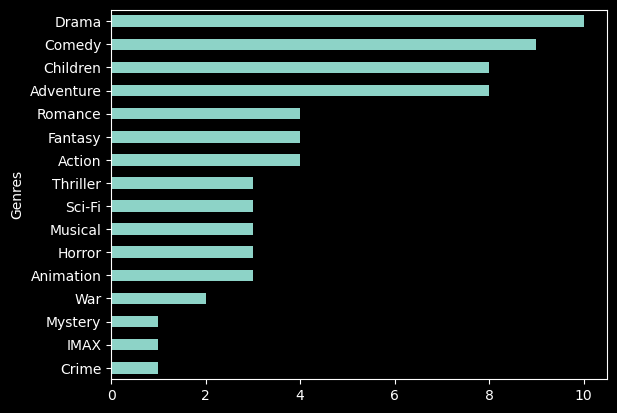

In [35]:
# Choose a user (IDX) - between 0 and 609.
user_IDX = 91

# Print user ID using dictionary
u_id = userIDX_to_userId[91]

# Display movies that user has already watched
show_movies_for_user(u_id)

# Show genre histogram of the user
show_genres_histogram_for_user(u_id)

Let's now use our predictor function to predict the ratings user index 91 would give to movies they have not watched. We create a dictionary (i_id, rating) with the predicted ratings for the movies, and loop through our first 50 movies index. 

In [36]:
ratings_predicted = {}
for i_id in range(50):
    if (u_id, i_id) not in R_dok: # user should not have already watched the movie
        #Predict rating of user for movie i_id
        ratings_predicted[i_id] = predict_rating(u_id, i_id, k=50, with_deviations=True, with_abs_sim=False)    

Movie name: Grumpier Old Men (1995)
User idx 92 has not rated movie idx 2.
k: 50, with_deviations: True, with_abs_sim: False
Prediction: 4.025704325758416 (user average: 4.288659793814433, offset: -0.2629554680560172)
Movie name: Waiting to Exhale (1995)
User idx 92 has not rated movie idx 3.
k: 50, with_deviations: True, with_abs_sim: False
Prediction: 3.1840816143386945 (user average: 4.288659793814433, offset: -1.104578179475738)
Movie name: Father of the Bride Part II (1995)
User idx 92 has not rated movie idx 4.
k: 50, with_deviations: True, with_abs_sim: False
Prediction: 3.981276632632755 (user average: 4.288659793814433, offset: -0.30738316118167813)
Movie name: Heat (1995)
User idx 92 has not rated movie idx 5.
k: 50, with_deviations: True, with_abs_sim: False
Prediction: 4.738601085222784 (user average: 4.288659793814433, offset: 0.44994129140835104)
Movie name: Sabrina (1995)
User idx 92 has not rated movie idx 6.
k: 50, with_deviations: True, with_abs_sim: False
Prediction:

Finally, we print the top 5 predicted rating:

In [37]:
# Sort dictionary and print top 5 movies
top_ratings = sorted(ratings_predicted.values(), reverse=True)[:5] # first 5 movies
for idx, rating in ratings_predicted.items():  
    if rating in top_ratings:
        print(get_name_for_movie_id(movieIDX_to_movieId[idx]))

Heat (1995)
Persuasion (1995)
Cry, the Beloved Country (1995)
Usual Suspects, The (1995)
Lamerica (1994)


## Using the Surprise library

[Surprise](http://surpriselib.com/) is a Python [scikit](https://projects.scipy.org/scikits.html) for building and analyzing recommender systems that deal with explicit rating data. You can install the package using the following code line in your terminal:

```python
pip install surprise
```

We will use the 100k dataset from MovieLens, which is already available in the Surprise library. Information about the dataset is available [here](https://grouplens.org/datasets/movielens/).

In [38]:
# Load data
data = Dataset.load_builtin('ml-100k')

# Training set
trainset = data.build_full_trainset()

# Number of movies
print('The dataset contains {} movies.'.format(len(trainset.all_items())))

# Number of movies
print('The dataset contains {} users.'.format(len(trainset.all_users())))

The dataset contains 1682 movies.
The dataset contains 943 users.


### Building a recommender system

We will create a KNN model. The `KNNWithMeans` function is using as parameter:
- `k`: (maximum) number of neighbors
- `min_k`: minimum number of neighbors
- `sim_options`: dictionary of options for the similarity measure. We are going to use:
    - `'name': 'pearson'`: Pearson similarity which can be seen as mean-centered cosine similarity,
    - `'user_based': True`: User-based collaborative filtering
- `verbose`: whether to print trace messages of bias estimation, similarity, etc. 

Check the [Documentation](https://surprise.readthedocs.io/en/stable/knn_inspired.html) for further information.

In [39]:
# Define options
sim_options = {
    'name': 'pearson', 
    'user_based': True 
}

# Create instance of class
knn_means = KNNWithMeans(k=40, min_k=1, sim_options=sim_options, verbose=False)

Next, we train our model and compute predictions on the test set (Note that the training might take a bit of time):

In [40]:
# Fit model
knn_means.fit(trainset)

# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset() 
predictions = knn_means.test(testset)

Let's check how the predictions look:

In [41]:
# Examples of predictions
predictions[0]

Prediction(uid='196', iid='302', r_ui=3.52986, est=4.034246763936509, details={'actual_k': 40, 'was_impossible': False})

Here are the output we get:
- `uid` is the user id
- `iid` is the item id
- `r_ui` is the true rating
- `est` is the estimated rating

That's it!. In less than 10 lines, we managed to do the same as in the first part... Packages are great!

### Visualizing the recommendations

We have built the predictions. Now we can visualize them. We first write these helpers functions.

In [42]:
def read_item_names():
    '''Read the u.item file from MovieLens 100-k dataset and return two
    mappings to convert raw ids into movie names and movie names into raw ids.
    '''

    file_name = get_dataset_dir() + '/ml-100k/ml-100k/u.item'
    rid_to_name = {}
    name_to_rid = {}
    with io.open(file_name, 'r', encoding='ISO-8859-1') as f:
        for line in f:
            line = line.split('|')
            rid_to_name[line[0]] = line[1]
            name_to_rid[line[1]] = line[0]

    return rid_to_name, name_to_rid


def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list) # This is used to group a sequence of key-value pairs into a dictionary of lists
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

We can see for each user what are the top recommended movies:

In [43]:
# Get top 10 movies for all users
top_n = get_top_n(predictions, n=10)

# Read the mappings row id <-> movie name
rid_to_name, name_to_rid = read_item_names()

# Print the recommended items for user id 135
uid = '135'
user_ratings = top_n[uid]
recommended_items = [iid for (iid, _) in user_ratings]
print(f'Recommended items for user id {uid}: ',', '.join(recommended_items))

# Convert ids into names
item_names = [rid_to_name[rid]
              for rid in recommended_items]
print(f'\nRecommended movies for user id {uid}: ', ', '.join(item_names))

print('\nMovies list:')
# Show name, url and covers
for name in item_names:
    print('\nName: ', name)
    clean_name = re.sub(r'\([^)]*\)', '', name) # Remove year of the movie (in between paranthesis)
    try:
        url = TMDB_class.TMDB().get_poster_path_by_name(clean_name)
    except:
        url = None
    print('url: ', url)
    if url:
        display(Image(url=url))

Recommended items for user id 135:  1463, 814, 1536, 1467, 1599, 1642, 1629, 1449, 1293, 1662

Recommended movies for user id 135:  Boys, Les (1997), Great Day in Harlem, A (1994), Aiqing wansui (1994), Saint of Fort Washington, The (1993), Someone Else's America (1995), Some Mother's Son (1996), Nico Icon (1995), Pather Panchali (1955), Star Kid (1997), Rough Magic (1995)

Movies list:

Name:  Boys, Les (1997)
url:  http://image.tmdb.org/t/p/w200/s2wI2QZDm4s8mFATMVRDvdOsF73.jpg



Name:  Great Day in Harlem, A (1994)
url:  http://image.tmdb.org/t/p/w200/606IorDjRMQZYaEdPBvjM8uI6qm.jpg



Name:  Aiqing wansui (1994)
url:  None

Name:  Saint of Fort Washington, The (1993)
url:  http://image.tmdb.org/t/p/w200/e8ie1x22wFEo63LQBbpBDqIH4oY.jpg



Name:  Someone Else's America (1995)
url:  http://image.tmdb.org/t/p/w200/xtJfxmlIe3iRFFTP4TNFRwacVz.jpg



Name:  Some Mother's Son (1996)
url:  http://image.tmdb.org/t/p/w200/ngy7zafrXEDCUOPfolcbFofMDmI.jpg



Name:  Nico Icon (1995)
url:  http://image.tmdb.org/t/p/w200/4qO219U8z1XeHLni800jCsbpSs0.jpg



Name:  Pather Panchali (1955)
url:  http://image.tmdb.org/t/p/w200/frZj5djlU9hFEjMcL21RJZVuG5O.jpg



Name:  Star Kid (1997)
url:  http://image.tmdb.org/t/p/w200/zspMlOFJ76g5KyfmucgnvnkJnuN.jpg



Name:  Rough Magic (1995)
url:  http://image.tmdb.org/t/p/w200/qbvAwn5XjNq4sn4ruT7nOet7unn.jpg


### Precision and Recall at rank k

We can evaluate the performance of our recommender using the precision and recall at rank k. Let's first create a function that returns the precision and recall at rank k for each user:

In [44]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

Now we train the same model as before, this time splitting our dataset into training and test set. Then, we compute the precision and recall for various ranks:

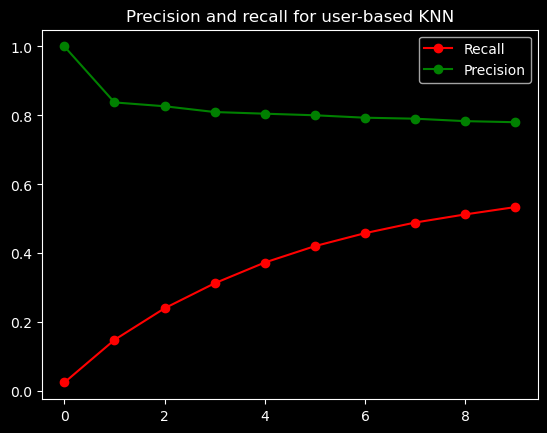

Precision @ 20 for user-based knn 0.7557728852865084
Recall @ 20 for user-based knn 0.6449069533144288


In [45]:
# Create training and test set
trainset, testset = train_test_split(data, test_size=0.2)

# Instance of KNNWithMeans
algo = KNNWithMeans(k=40, min_k=1, sim_options=sim_options, verbose=False)

# Fit model on training set
algo.fit(trainset)

# Predict test set values
predictions = algo.test(testset)

# Compute precision and recall for k between 0 and 9
precision = []
recall = []
for k in range(10):
    # rating > 3.5 = relevant, rating < 3.5 = irrelevant
    precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)
    # Precision and recall can then be averaged over all users
    precision.append( sum(prec for prec in precisions.values()) / len(precisions) )
    recall.append( sum(rec for rec in recalls.values()) / len(recalls) )

# Plot
plt.plot(range(10), recall, 'ro-', label="Recall")
plt.plot(range(10), precision, 'go-', label="Precision")
plt.legend()
plt.title("Precision and recall for user-based KNN")
plt.show();

# Precision and recall at rank 20:
precisions, recalls = precision_recall_at_k(predictions, k=20, threshold=3.5)
print("Precision @ 20 for user-based knn", sum(prec for prec in precisions.values()) / len(precisions))
print("Recall @ 20 for user-based knn", sum(rec for rec in recalls.values()) / len(recalls))

### Precision-recall curve

We will now observe the area under precision recall curve for two methods: SVD ([Documentation](https://surprise.readthedocs.io/en/stable/matrix_factorization.html)) and KNN. We first create a function that takes as input an instance of algorithm and returns the precision and recall as calculated above:

In [46]:
def precision_recall_algo(algo):
    '''Return precision and recall at k metrics for an algorithm.'''    
    
    # Fit algo on training set
    algo.fit(trainset)
    
    # Predict on test set
    predictions = algo.test(testset)
    
    # Compute precision and recall
    precision = []
    recall = []
    for k in range(20):
        precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)
        precision.append( sum(prec for prec in precisions.values()) / len(precisions) )
        recall.append( sum(rec for rec in recalls.values()) / len(recalls) ) 
    
    return precision, recall

Let's plot our precision-recall curves for our two algorithms:

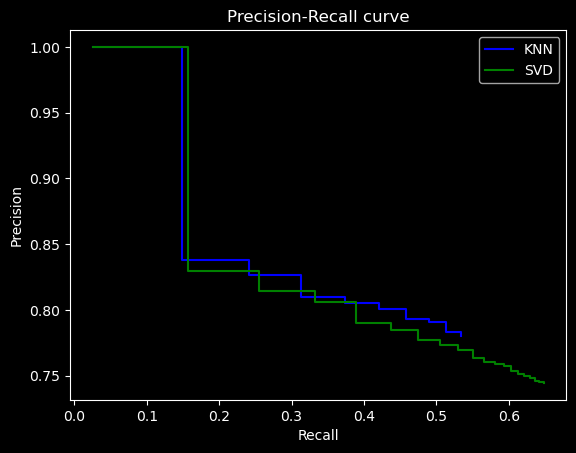

In [47]:
# KNN precision and recall
algo_KNN =  KNNWithMeans(k=40, min_k=1, sim_options=sim_options, verbose=False)
precision_KNN, recall_KNN = precision_recall_algo(algo_KNN)

# SVD precision and recall
algo_SVD = SVD()
precision_SVD, recall_SVD = precision_recall_algo(algo_SVD)

# Plot
plt.step(recall, precision, color='b', where='post', label ='KNN')
plt.step(recall_SVD, precision_SVD, color='g', where='post', label ='SVD')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall curve');

### Cross-validation

The Surprise library also provides built-in cross-validation to split the data to multiple folds ([Documentation](https://surprise.readthedocs.io/en/stable/model_selection.html#cross-validation)).

In [48]:
# Define options
sim_options = {
    'name': 'pearson',
    'user_based': True 
}

# Create instance of KNNWithMeans
knn_means = KNNWithMeans(k=40, min_k=1, sim_options=sim_options, verbose=False)

# Run 5-fold cross-validation and print results
cross_validate(knn_means, data, measures=['RMSE'], cv=5, verbose=True);

Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9527  0.9439  0.9446  0.9482  0.9597  0.9498  0.0059  
Fit time          1.31    1.11    1.08    0.99    1.05    1.11    0.11    
Test time         2.41    2.38    2.38    2.25    2.29    2.34    0.06    


### Tuning hyper-parameters

We can also use `GridSearchCV` ([Documentation](https://surprise.readthedocs.io/en/stable/model_selection.html#surprise.model_selection.search.GridSearchCV)) to tune the hyper-parameters of our recommender system, e.g., tuning the number of neighbours in KNN:

In [49]:
param_grid={'k': [20, 30, 40, 50], 
            'sim_options': {'name': ['pearson'], 'user_based': [True]}}

KNN_grid_search = GridSearchCV(KNNWithMeans, param_grid=param_grid, 
                               measures=['RMSE'], cv=5,
                               refit=True, joblib_verbose=2, n_jobs=-1)

KNN_grid_search.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   10.3s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   13.2s finished


Computing the pearson similarity matrix...
Done computing similarity matrix.


Let's print the results:

In [50]:
print('Best parameter:', KNN_grid_search.best_params)
print('Best RMSE: ', KNN_grid_search.best_score)
# We can even see the whole cv results
KNN_grid_search.cv_results

Best parameter: {'rmse': {'k': 50, 'sim_options': {'name': 'pearson', 'user_based': True}}}
Best RMSE:  {'rmse': 0.9486736013721808}


{'split0_test_rmse': array([0.9485, 0.9431, 0.9409, 0.9402]),
 'split1_test_rmse': array([0.9604, 0.9555, 0.9534, 0.9525]),
 'split2_test_rmse': array([0.9611, 0.9546, 0.9524, 0.9516]),
 'split3_test_rmse': array([0.9628, 0.9564, 0.9538, 0.9526]),
 'split4_test_rmse': array([0.9567, 0.9493, 0.9472, 0.9465]),
 'mean_test_rmse': array([0.9579, 0.9518, 0.9495, 0.9487]),
 'std_test_rmse': array([0.0051, 0.005 , 0.0049, 0.0048]),
 'rank_test_rmse': array([4, 3, 2, 1], dtype=int64),
 'mean_fit_time': array([2.8252, 2.9127, 2.8515, 2.3003]),
 'std_fit_time': array([0.164 , 0.0867, 0.146 , 0.1527]),
 'mean_test_time': array([3.7883, 4.3461, 4.7891, 3.0571]),
 'std_test_time': array([0.1739, 0.1713, 0.0541, 0.9498]),
 'params': [{'k': 20, 'sim_options': {'name': 'pearson', 'user_based': True}},
  {'k': 30, 'sim_options': {'name': 'pearson', 'user_based': True}},
  {'k': 40, 'sim_options': {'name': 'pearson', 'user_based': True}},
  {'k': 50, 'sim_options': {'name': 'pearson', 'user_based': True

Finally, let's extract the best model and predict the rating given by user id 6 to movie id 908:

In [51]:
best_model_knn = KNN_grid_search.best_estimator['rmse']
best_model_knn.predict('6', '908')

Prediction(uid='6', iid='908', r_ui=None, est=2.8404324339671865, details={'actual_k': 16, 'was_impossible': False})